Workbook for Universal Sentence Encoder and topic modeling.

In [2]:
import pandas as pd

# Load the CSV data into a DataFrame
jokes_df = pd.read_csv('jokes_dataset.csv')

# print the first 5 rows of the DataFrame
print(jokes_df.head())


                                                text  humor
0  Joe biden rules out 2020 bid: 'guys, i'm not r...  False
1  Watch: darvish gave hitter whiplash with slow ...  False
2  What do you call a turtle without its shell? d...   True
3      5 reasons the 2016 election feels so personal  False
4  Pasco police shot mexican migrant from behind,...  False


In [3]:
import nltk
from nltk.corpus import stopwords
import string
import re

# Download the stopwords corpus
nltk.download('stopwords')

# Define a function to preprocess the jokes
def preprocess_jokes(jokes_df):
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    jokes_df['clean_joke'] = jokes_df['text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if (word.lower() not in stop_words) and (word.lower() not in string.punctuation)]))
    return jokes_df

# Define a function to remove punctuation
def remove_punctuation(text):
    # Define the regular expression pattern to match any punctuation character
    pattern = r'[^\w\s]'

    # Use the sub() function to replace any matches with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:

# Preprocess the jokes
preprocess_jokes(jokes_df)

# Apply the remove_punctuation function to the Clean_joke column
jokes_df['clean_joke'] = jokes_df['clean_joke'].apply(remove_punctuation)


In [5]:

humorous_jokes_df = jokes_df[jokes_df['humor'] == True]


Universal Sentence Encoder:

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

# Load the model from TensorFlow Hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
model = hub.load(module_url)


In [7]:
# Define batch size
BATCH_SIZE = 1000

# Initialize empty list to store encoded joke vectors
joke_vectors_list = []

# Encode jokes in batches
for i in range(0, len(humorous_jokes_df), BATCH_SIZE):
    # Get a batch of jokes
    batch_jokes = humorous_jokes_df["clean_joke"][i:i+BATCH_SIZE]
    
    # Encode the batch of jokes into vectors
    batch_vectors = model(batch_jokes).numpy()
    
    # Append the batch of vectors to the list
    joke_vectors_list.append(batch_vectors)



In [8]:
import numpy as np

    
# Concatenate the list of vectors into a single numpy array
joke_vectors_array = np.concatenate(joke_vectors_list)

# Print the shape of the joke vectors array
print(joke_vectors_array.shape)

(100000, 512)


In [9]:
print(joke_vectors_array[:10])


[[-0.10272926 -0.01983313 -0.00284022 ... -0.00134287 -0.0245461
   0.02391309]
 [ 0.00263279  0.08414213  0.02961861 ...  0.04268469  0.07342681
   0.04781407]
 [ 0.02592236 -0.01635438 -0.02989341 ... -0.01631698 -0.07111952
   0.03338585]
 ...
 [ 0.04659941 -0.0460685  -0.00383115 ...  0.03140274  0.04096763
   0.05693741]
 [ 0.06997935 -0.06368115 -0.0437464  ... -0.07381413  0.01135412
  -0.00506185]
 [ 0.01967495 -0.00077027  0.06616988 ... -0.01556989  0.04132042
   0.03782702]]


Need to save the joke_vectors array for later use with streamlit app.

In [10]:
# Save the array as an npy file
np.save("joke_vectors.npy", joke_vectors_array)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

batch_size = 1000

similarity_matrix = None

# Compute the pairwise cosine similarity between all joke vectors in batches
for i in range(0, len(joke_vectors_array), batch_size):
    batch_vectors = joke_vectors_array[i:i+batch_size]
    if len(batch_vectors) < batch_size:  # pad the last batch if necessary
        num_padding_rows = batch_size - len(batch_vectors)
        padding_vectors = np.zeros((num_padding_rows, joke_vectors_array.shape[1]))
        batch_vectors = np.concatenate([batch_vectors, padding_vectors], axis=0)
    if similarity_matrix is None:
        similarity_matrix = cosine_similarity(batch_vectors)
    else:
        similarity_matrix = np.concatenate(
            [similarity_matrix, cosine_similarity(batch_vectors)], axis=0)

# Print the shape of the similarity matrix
print(similarity_matrix.shape)


(100000, 1000)


Need to save the similarity_matrix array for later use with streamlit app.

In [12]:
  # Save the array as an npy file
np.save("simalarity_matrix.npy", similarity_matrix)

In [13]:
import tensorflow_hub as hub

# Load the Universal Sentence Encoder model from TensorFlow Hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Jokes-Capstone'


/content/drive/My Drive/Jokes-Capstone


In [ ]:
import shutil
shutil.copy('/content/joke_vectors.npy', '/content/drive/MyDrive/Jokes-Capstone/joke_vectors.npy')


'/content/drive/MyDrive/Jokes-Capstone/joke_vectors.npy'

In [ ]:
import shutil
shutil.copy('/content/simalarity_matrix.npy', '/content/drive/MyDrive/Jokes-Capstone/simalarity_matrix.npy')


'/content/drive/MyDrive/Jokes-Capstone/simalarity_matrix.npy'

In [21]:
# Given a user's input, encode it into a vector representation using the same Universal Sentence Encoder model.
user_input = input("Enter a sentence: ")


Enter a sentence: Dr. Seuss cat in the hat


In [22]:
user_input_vector = embed([user_input])[0].numpy()
similarity_scores = cosine_similarity(user_input_vector.reshape(1, -1), joke_vectors_array)

In [26]:
# Get the number of jokes to recommend from the user
num_jokes = int(input("How many jokes would you like to see? "))

How many jokes would you like to see? 5


In [27]:
# Get the top-n jokes with the highest similarity scores
top_indices = np.argsort(similarity_scores, axis=1)[:, ::-1][:, :num_jokes].ravel()

In [28]:
top_jokes = [humorous_jokes_df.iloc[i] for i in top_indices]

In [29]:
top_jokes

[text          What did dr. seuss call the book he wrote abou...
 humor                                                      True
 clean_joke          dr seuss call book wrote star wars cat atat
 Name: 151470, dtype: object,
 text          What was schrodinger's favorite childhood book...
 humor                                                      True
 clean_joke    schrodingers favorite childhood book cat box d...
 Name: 42771, dtype: object,
 text          What is dr. seuss' favorite play? green eggs a...
 humor                                                      True
 clean_joke             dr seuss favorite play green eggs hamlet
 Name: 87722, dtype: object,
 text          Did you read dr seuss as a kid because green e...
 humor                                                      True
 clean_joke                    read dr seuss kid green eggs damn
 Name: 150734, dtype: object,
 text          What do you call a magician in a dr. seuss boo...
 humor                               

In [30]:
# Print the top-n jokes
print(f"Top {num_jokes} jokes:")
for i, joke in enumerate(top_jokes):
    print(f"{i+1}. {joke.text}")


Top 5 jokes:
1. What did dr. seuss call the book he wrote about star wars? the cat in the at-at
2. What was schrodinger's favorite childhood book? the cat in the box by dr. seuss
3. What is dr. seuss' favorite play? green eggs and hamlet
4. Did you read dr seuss as a kid because green eggs and damn
5. What do you call a magician in a dr. seuss book? who-dini


Topic modeling:

LDA (Latent Dirichlet Allocation) is used as a probabilistic topic modeling technique to discover latent topics in a collection of documents. We model each topic as a probability distribution over the words in the vocabulary to explain the topic-word distributions that best explain the observed document-word occurrences.

For topic modeling with LDA, lemmatization, tokenization and vectorization are used to prepare the text data for input into the model. 

In [44]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer


nltk.download('punkt')

# Download NLTK data
nltk.download('wordnet')

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a single document
def lemmatize_doc(doc):
    tokens = nltk.word_tokenize(doc)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Lemmatize the text data
humorous_jokes_df['lemmatized_joke'] = humorous_jokes_df['clean_joke'].apply(lemmatize_doc)

# Create a TfidfVectorizer object to tokenize the lemmatized text data
vectorizer = TfidfVectorizer(stop_words='english')

# Tokenize the lemmatized text data
tokenized_data = vectorizer.fit_transform(humorous_jokes_df['lemmatized_joke'])

# Train the LDA model on the tokenized data
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(tokenized_data)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-44-2ce97984cfcc>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humorous_jokes_df['lemmatized_joke'] = humorous_jokes_df['clean_joke'].apply(lemmatize_doc)


LatentDirichletAllocation(n_components=5, random_state=42)

In [45]:

# Print the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for i in range(num_topics):
    print("Topic %d:" % i)
    topic_words = np.array(feature_names)[np.argsort(lda_model.components_[i])][:-11:-1]
    for word in topic_words:
        print("  %s" % word)
    print()


Topic 0:
  joke
  mexican
  whats
  make
  say
  trump
  change
  im
  like
  want

Topic 1:
  like
  joke
  chicken
  whats
  say
  im
  know
  people
  tell
  woman

Topic 2:
  walk
  bar
  say
  man
  im
  whats
  people
  like
  guy
  got

Topic 3:
  like
  say
  whats
  woman
  black
  know
  im
  people
  make
  coffee

Topic 4:
  im
  like
  people
  knock
  know
  hear
  girl
  time
  whats
  say



Text classification and information retrieval systems often rely on the identification of topics within a set of documents, so topic modeling can be a useful tool in these areas. Additionally, topic modeling can also be used for recommendation systems by identifying topics that are relevant to a user's interests and suggesting items that match those topics.

Use t-SNE to reduce the dimensionality of the topic distributions for each document generated by the LDA model into a two-dimensional space for visualization.

In [46]:
from sklearn.manifold import TSNE

# Get topic distributions for each document
doc_topics = lda_model.transform(tokenized_data)

# Perform t-SNE on the topic distributions
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_jobs=-1, perplexity=50)
tsne_lda = tsne_model.fit_transform(doc_topics)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.102s...
[t-SNE] Computed neighbors for 100000 samples in 6.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probab

Visualize the top words for each topic using LDA.

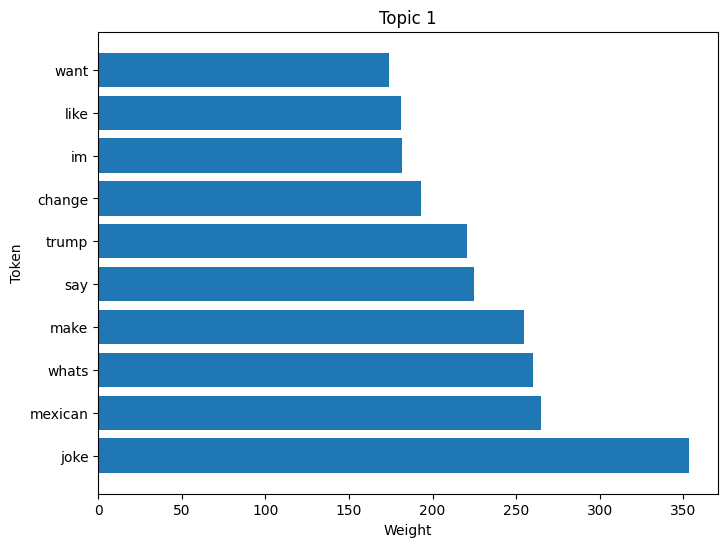

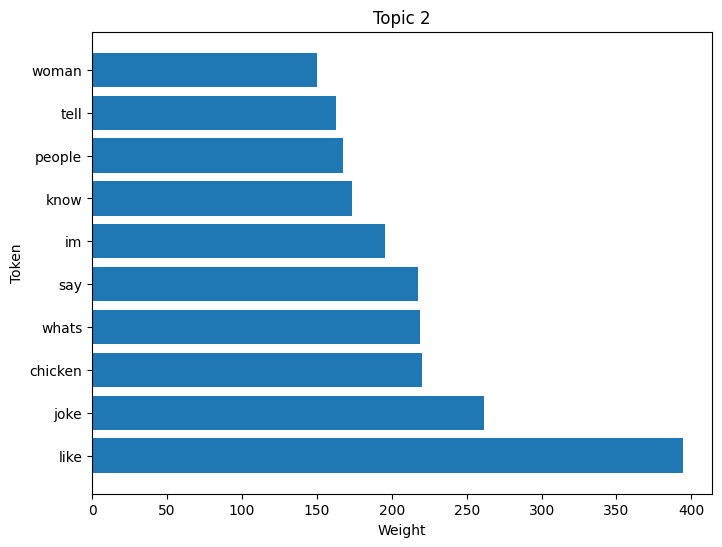

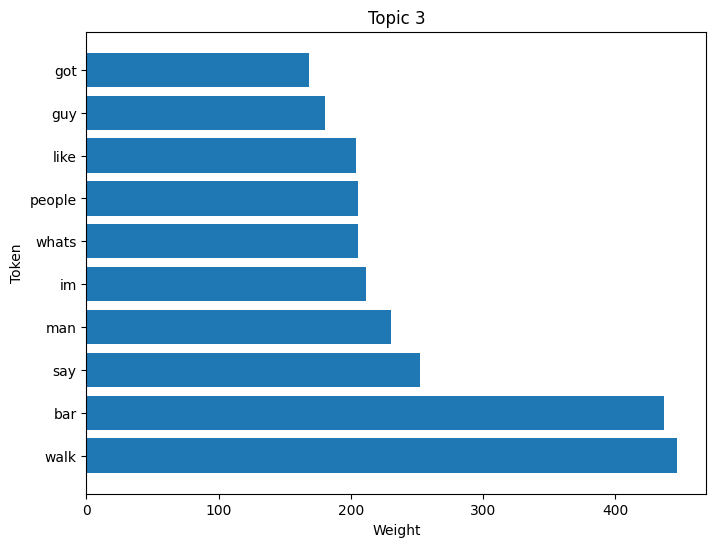

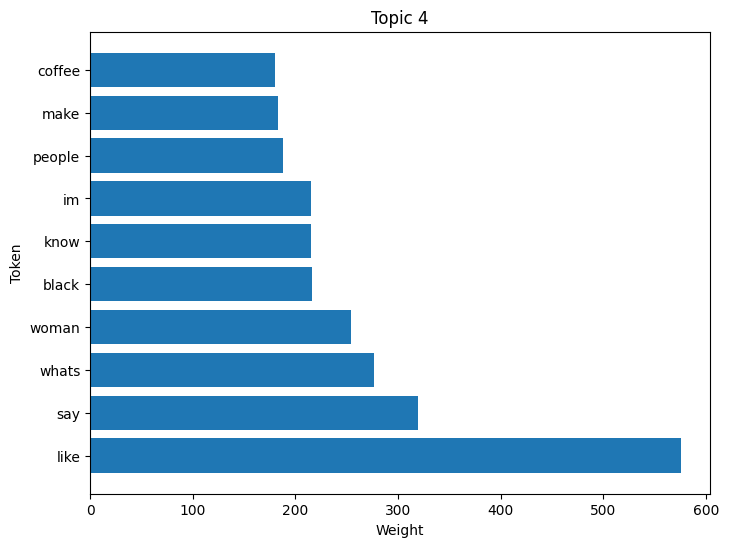

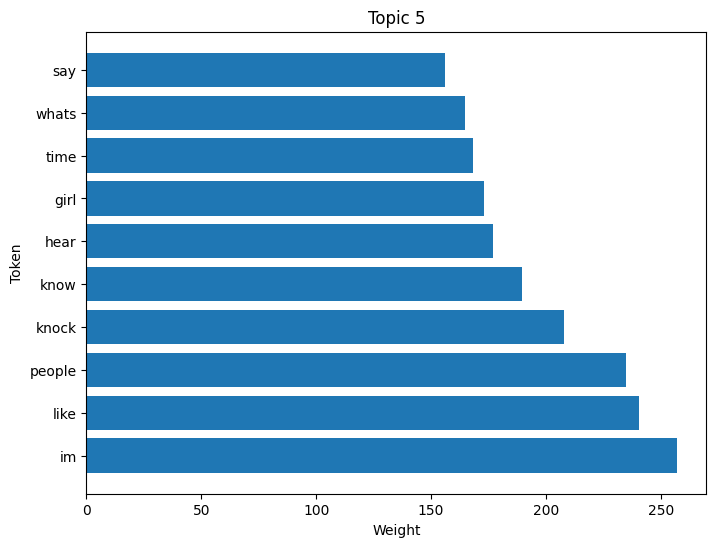

In [47]:
import matplotlib.pyplot as plt

# Define a function to get the top tokens for each topic and their corresponding weights
def get_top_tokens(model, feature_names, n_top_tokens):
    top_tokens = []
    top_weights = []
    for topic_idx, topic in enumerate(model.components_):
        top_tokens_idx = topic.argsort()[:-n_top_tokens - 1:-1]
        top_tokens.append([feature_names[i] for i in top_tokens_idx])
        top_weights.append(topic[top_tokens_idx])
    return top_tokens, top_weights

# Create a list of feature names from the vectorizer object
feature_names = vectorizer.get_feature_names_out()

# Get the top tokens for each topic and their corresponding weights
n_top_tokens = 10
top_tokens, top_weights = get_top_tokens(lda_model, feature_names, n_top_tokens)

# Create a bar plot for each topic
for i, tokens in enumerate(top_tokens):
    plt.figure(figsize=(8,6))
    plt.barh(tokens, top_weights[i])
    plt.title(f'Topic {i+1}')
    plt.xlabel('Weight')
    plt.ylabel('Token')
    plt.show()


Print topic-term matrix using LDA modeling.

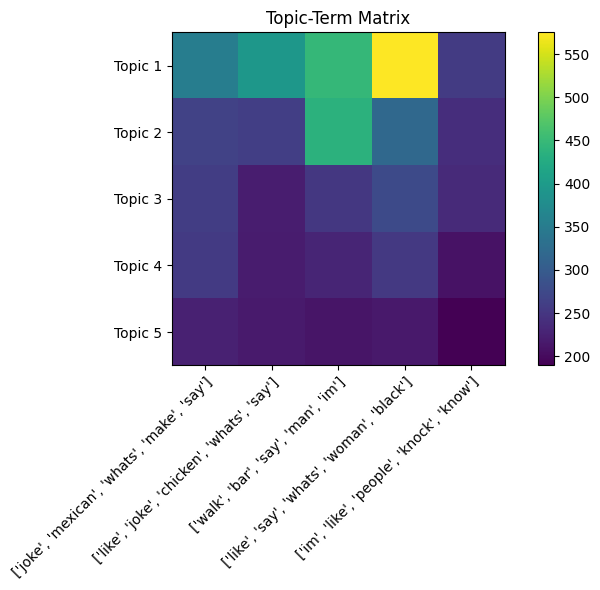

In [49]:
import matplotlib.pyplot as plt

# Define a function to get the top tokens for each topic and their corresponding weights
def get_top_tokens(model, feature_names, n_top_tokens):
    top_tokens = []
    top_weights = []
    for topic_idx, topic in enumerate(model.components_):
        top_tokens_idx = topic.argsort()[:-n_top_tokens - 1:-1]
        top_tokens.append([feature_names[i] for i in top_tokens_idx])
        top_weights.append(topic[top_tokens_idx])
    return top_tokens, top_weights

# Create a list of feature names from the vectorizer object
feature_names = vectorizer.get_feature_names_out()

# Get the top tokens for each topic and their corresponding weights
n_top_tokens = 5
top_tokens, top_weights = get_top_tokens(lda_model, feature_names, n_top_tokens)

# Create a topic-term matrix
topic_term_matrix = []
for i in range(len(top_tokens)):
    topic_term_matrix.append(top_weights[i])

# Transpose the matrix so that each row represents a term and each column represents a topic
topic_term_matrix = np.array(topic_term_matrix).T

# Create a heatmap of the topic-term matrix
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(topic_term_matrix, cmap='viridis')

# Set axis labels and tick labels
ax.set_xticks(np.arange(len(top_tokens)))
ax.set_yticks(np.arange(len(lda_model.components_)))
ax.set_xticklabels(top_tokens)
ax.set_yticklabels([f'Topic {i+1}' for i in range(len(lda_model.components_))])

# Rotate the x-axis labels for better visibility
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set title and show plot
ax.set_title("Topic-Term Matrix")
fig.tight_layout()
plt.show()


Perform dimensionality reduction on a sample of text data using t-SNE algorithm. The y variable is used to provide labels for each document, indicating whether it is a joke or not. 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.110s...
[t-SNE] Computed neighbors for 20000 samples in 244.904s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

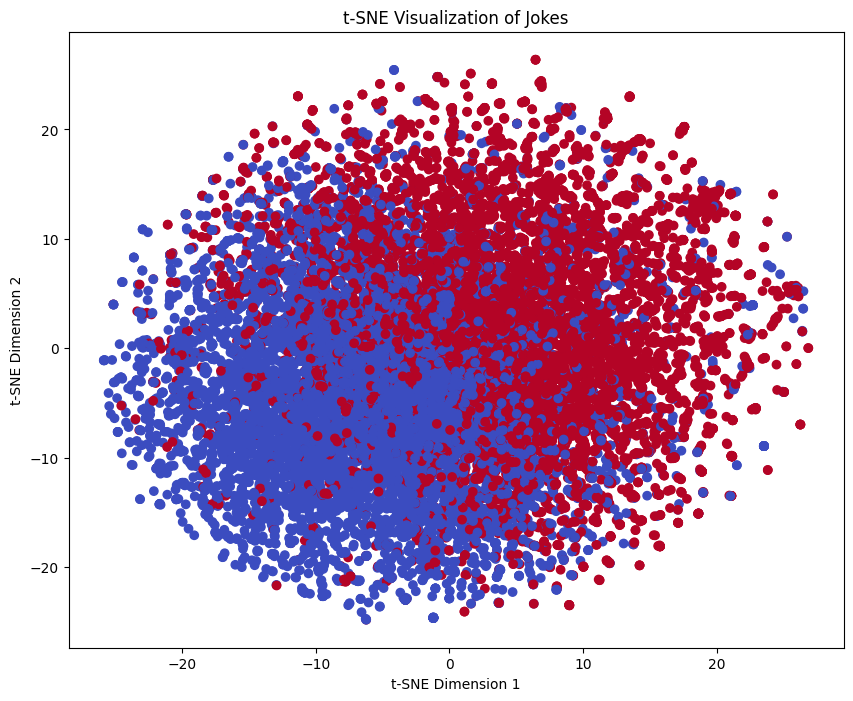

In [50]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

# Define lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize a list of tokens
def lemmatize(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Tokenize and lemmatize the text data
tokenized_data = [joke.split() for joke in jokes_sampled['clean_joke']]
lemmatized_data = [lemmatize(tokens) for tokens in tokenized_data]

# Convert the lemmatized data to a list of strings
text_data = [' '.join(tokens) for tokens in lemmatized_data]

# Create a TF-IDF vectorizer and fit it to the text data
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(text_data)

# Get labels for each document (joke vs. non-joke)
y = jokes_sampled['humor'].values  # replace with your label vector, where each element corresponds to the label for a document

# Perform t-SNE on the TF-IDF matrix with lower perplexity
tsne = TSNE(n_components=2, verbose=1, perplexity=30, random_state=42, n_jobs=-1)
tsne_results = tsne.fit_transform(tfidf.toarray())


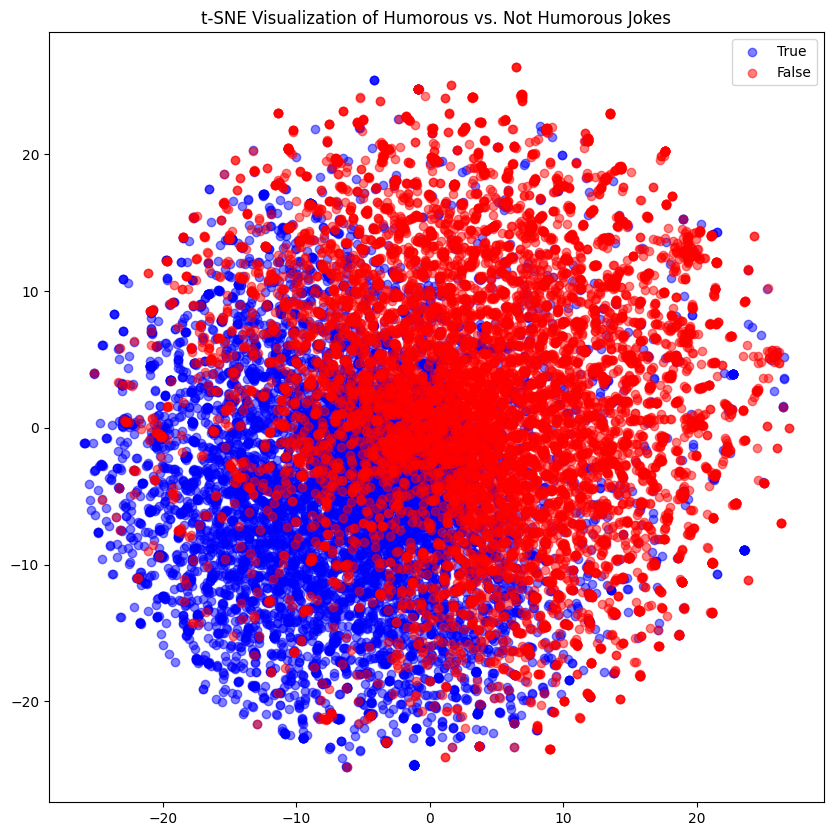

In [51]:
import numpy as np 

# Visualize the t-SNE results
fig, ax = plt.subplots(figsize=(10, 10))
colors = ['blue', 'red']
for i, label in enumerate([True, False]):
    ax.scatter(tsne_results[:, 0][np.where(y == i)], 
               tsne_results[:, 1][np.where(y == i)], 
               c=colors[i], label=label, alpha=0.5)
ax.legend()
ax.set_title('t-SNE Visualization of Humorous vs. Not Humorous Jokes')
plt.show()
